# Result VCT regression

In [2]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [141]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions
from phd.visualization.bokeh_plotting import create_tab
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm
import sympy as sp
from sympy import Eq, symbols, latex
import paper
from paper import save_fig, save_eq
import yaml
with open("styles.yml", mode='r') as file:
    styles = yaml.safe_load(file)
    
from phd.pipelines.predict.nodes import score

In [132]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")
model_loaders = catalog.load(f"{ship}.models_VCT_MDL")

df_VCT_scaled = catalog.load(f"{ship}.df_VCT_scaled")
tests_ek_smooth = catalog.load(f"{ship}.tests_ek_smooth")
tests_ek = catalog.load(f"{ship}.tests_ek")
tests_ek_joined = catalog.load(f"{ship}.tests_ek_joined")

mask = tests_ek_joined['id'].isin([
    #22774,  # Circle
    #22611,
    #22635,
    #22639,
    22769,
    22771,
])

tests_ek_smooth_joined = tests_ek_joined.loc[~mask].copy()

[01/15/24 16:00:24] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=944892;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=804390;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=686384;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=987842;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=212398;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=646904;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth' (PartitionedDataset)...   ]8;id=290828;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=275362;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek' (PartitionedDataset)...          ]8;id=20950;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=433118;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_joined' (CSVDataSet)...           ]8;id=99010;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=28874;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [5]:
model = model_loaders['semiempirical_covered']()

## Compare with MDL inverse dynamics
The forces from model tests in MDL can be estimated with inverse dynamics. These forces can be compared with forces predicted with the regressed models.

In [28]:
def preprocess(data_MDL):
    data_MDL['V'] = data_MDL['U'] = np.sqrt(data_MDL['u']**2 + data_MDL['v']**2)
    data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
    data_MDL['rev'] = data_MDL[['Prop/PS/Rpm','Prop/SB/Rpm']].mean(axis=1)
    data_MDL['twa']=0
    data_MDL['tws']=0
    data_MDL['theta']=0
    data_MDL['q']=0
    data_MDL['phi'] = data_MDL['roll']
    data_MDL['p'] = 0
    data_MDL['q1d'] = 0
    data_MDL['thrust_port'] = data_MDL['Prop/PS/Thrust']
    data_MDL['thrust_stbd'] = data_MDL['Prop/SB/Thrust']
    
    return data_MDL

In [29]:
#id = 22773
id = 22772
#id = 22770
#id = 22764
#id = 22774
#id = 22616  # Spiral


data_MDL = tests_ek_smooth[f'{id}']()
data_MDL_ek = tests_ek[f'{id}']()
preprocess(data_MDL)
preprocess(data_MDL_ek)

,x0,y0,psi,u,v,r,u1d,v1d,r1d,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,z0,V,U,thrust,rev,twa,tws,thrust_port,thrust_stbd,beta,theta,q,phi,p,q1d
0.000000,0.010682,8.082920e-07,-0.000611,0.972889,0.000603,8.844824e-07,-0.159545,-0.000309,0.045773,0.0,1.0,2.146755,0.000027,0.187446,0.0,-0.520477,10.131507,1.0,2.146755,-0.000706,0.231210,0.0,-8.160022,11.329219,0.021273,-0.030895,0.007658,0.015050,-0.007220,0.012022,9.558658,5.450189,-0.108403,9.564930,5.347577,0.100852,0.000014,0.645772,14.89,-0.000144,0.1,0.0,0.000125,0.000890,-0.000171,0.002476,0.972889,0.972889,10.797766,9.561794,0,0,5.450189,5.347577,-0.000620,0,0,0.000890,0,0
0.009931,0.017082,1.129842e-06,-0.000579,0.971305,0.000600,4.554541e-04,-0.037431,0.000054,-0.029367,0.0,1.0,2.146755,0.000035,0.037287,0.0,0.212813,10.131507,1.0,2.146755,-0.000929,0.206990,0.0,-6.481174,11.329219,-0.010323,0.089009,0.017337,0.033088,0.010187,0.044245,9.574600,5.416779,-0.111748,9.556027,5.263566,0.099891,0.000014,0.645772,14.89,-0.000190,0.1,0.0,0.000125,0.000850,0.000083,0.002564,0.971305,0.971305,10.680344,9.565313,0,0,5.416779,5.263566,-0.000618,0,0,0.000850,0,0
0.019862,0.027371,1.269224e-06,-0.000618,0.972146,0.000605,-5.823960e-04,-0.123344,0.000106,-0.045940,0.0,1.0,2.146755,0.000044,-0.170115,0.0,-0.366100,10.131507,1.0,2.146755,-0.001154,0.015996,0.0,-5.689993,11.329219,-0.014837,0.063223,0.017983,0.046616,0.009542,0.031356,9.653423,5.444381,-0.114711,9.565278,5.233857,0.100988,0.000020,0.645772,14.89,-0.000236,0.1,0.0,0.000125,0.000868,-0.000135,0.002566,0.972146,0.972146,10.678238,9.609350,0,0,5.444381,5.233857,-0.000622,0,0,0.000868,0,0
0.029793,0.035466,1.564520e-06,-0.000619,0.968855,0.000603,-4.570101e-04,-0.381859,-0.000256,0.012217,0.0,1.0,2.146755,0.000052,-0.285948,0.0,-0.173129,10.131507,1.0,2.146755,-0.001382,-0.180430,0.0,0.157031,11.329219,0.005152,0.072248,0.005076,0.054991,0.022437,0.019756,9.623491,5.517160,-0.116242,9.534870,5.259566,0.103520,0.000014,0.645772,14.89,-0.000283,0.1,0.0,0.000125,0.000850,0.000102,0.002481,0.968855,0.968855,10.776726,9.579180,0,0,5.517160,5.259566,-0.000622,0,0,0.000850,0,0
0.039724,0.043711,1.843651e-06,-0.000619,0.964561,0.000599,-3.397351e-04,-0.373160,-0.000313,0.010546,0.0,1.0,2.146755,0.000061,-0.218993,0.0,0.367190,10.131507,1.0,2.146755,-0.001606,-0.232356,0.0,-1.830571,11.329219,-0.010968,0.065157,0.014756,0.029223,0.016634,0.015245,9.603952,5.616301,-0.115943,9.572603,5.323262,0.106590,0.000014,0.645772,14.89,-0.000329,0.1,0.0,0.000125,0.000831,-0.000185,0.002655,0.964561,0.964561,10.939563,9.588278,0,0,5.616301,5.323262,-0.000622,0,0,0.000831,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71.016581,55.472342,1.215794e+00,-0.193415,0.776614,-0.085287,5.572480e-02,0.025440,-0.017753,0.007436,0.0,1.0,2.146755,0.057269,-0.106522,0.0,-0.153832,10.131507,1.0,2.146755,-1.515974,-0.015793,0.0,-1.946354,11.329219,-0.001941,0.100613,-0.004603,0.022781,-0.002063,-0.012466,9.511381,7.392989,-0.139509,9.580544,5.423067,0.113880,-0.349072,0.645772,14.89,-0.310125,0.1,0.0,-0.000550,-0.007266,-0.000066,0.001469,0.781283,0.781283,12.816056,9.545963,0,0,7.392989,5.423067,0.109380,0,0,-0.007266,0,0
71.026512,55.479876,1.213440e+00,-0.192861,0.776851,-0.085457,5.578257e-02,0.005256,-0.015183,-0.001356,0.0,1.0,2.146755,0.057201,-0.098690,0.0,0.039139,10.131507,1.0,2.146755,-1.514175,-0.025439,0.0,4.769040,11.32

In [30]:
models = {
    'Reference model': model,    
}

[01/15/24 17:28:41] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=659863;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=945355;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_4370/2301622738.py:5: UserWarning: The figure layout    ]8;id=610273;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=670675;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             has changed to tight                                                                  
                               plt.tight_layout()                                                                  
                                                                                                                   

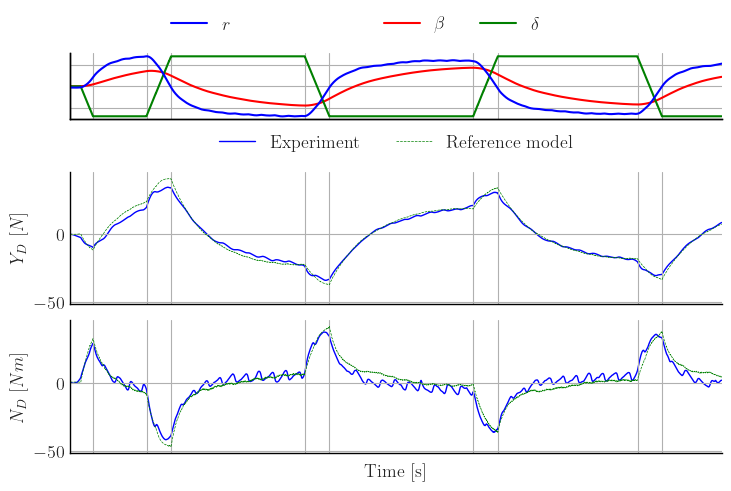

In [142]:
fig = plot_compare_model_forces(model=model, models=models, data=data_MDL, keys=['Y_D','N_D'], styles=styles)
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=2)
fig.axes[3].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2)
plt.tight_layout()
fig.savefig(paper.file_path_with_nb_ref("VCT_regression_ID.pdf"))

In [32]:
model = models['Reference model']

In [33]:
data = data_MDL
forces_from_motions = model.forces_from_motions(data=data)
df_predict = predict(model=model, data=data)

<Axes: >

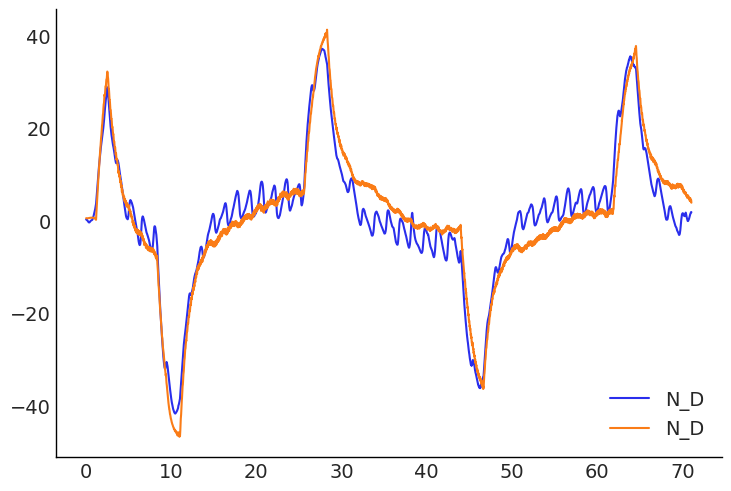

In [34]:
fig,ax=plt.subplots()
forces_from_motions.plot(y='N_D',ax=ax)
df_predict.plot(y='N_D', ax=ax)

## Other tests

In [35]:
mean_absolute_error(y_true=forces_from_motions['N_D'], y_pred=df_predict['N_D'])

3.658280442542031

In [36]:
r2_score(y_true=forces_from_motions['N_D'], y_pred=df_predict['N_D'])

0.908957179559628

In [82]:
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")

[01/15/24 13:21:21] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=460823;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=865272;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [133]:
_ = []
ids = tests_ek_smooth_joined['id'].unique()
for id in ids:
    
    loader = tests_ek_smooth[str(id)]
    data = loader()
    preprocess(data)
    try:
        s = score(model=model, data=data)
    except:
        print(f"Skipping {id}")
        continue
        
    _.append(pd.Series(s, name=id))
    
df_scores = pd.DataFrame(_)

[01/15/24 16:00:43] WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/pandas/core/ ]8;id=642908;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=207776;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt                   
                               result = getattr(ufunc, method)(*inputs, **kwargs)                                  
                                                                                                                   

                    WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/pandas/core/ ]8;id=484046;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=905381;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt                   
                               result = getattr(ufunc, method)(*inputs, **kwargs)                                  
                                                                                                                   

Skipping 22862


In [135]:
steals = [
    'test_type',
    'angle1',
    'ship_speed',
]
for steal in steals:
    df_scores[steal] = time_series_meta_data[steal]

In [136]:
mask = df_scores['test_type'] == 'rodergrundvinkel'
df_scores.loc[mask,'test_type'] = 'yaw rate'

mask = df_scores['test_type'] == 'reference speed'
df_scores.loc[mask,'test_type'] = 'ref. speed'

mask = df_scores['test_type'] == 'zigzag'
df_scores.loc[mask,'Description'] = df_scores.loc[mask].apply(lambda x:f"{x['test_type']}{int(x['angle1'])}/{int(x['angle1'])}", axis=1)
df_scores.loc[~mask,'Description'] = df_scores.loc[~mask,'test_type']

In [137]:
df_scores.sort_values(by=['Description','ship_speed'], inplace=True, ascending=False)

In [138]:
df_scores_table = df_scores[['Description','ship_speed','X_D','Y_D','N_D']].copy()
df_scores_table.rename(columns={
    'ship_speed': r'V',
    'X_D': r'$X_D$ $[N]$',
    'Y_D': r'$Y_D$ $[Nm]$',
    'N_D': r'$N_D$ $[Nm]$',
    
}, inplace=True)

In [139]:
df_scores_table.to_csv(paper.file_path_with_nb_ref("reference_model_mean_average_error.csv", directory='tables'), index=False)

In [140]:
df_scores_table

,Description,V,$X_D$ $[N]$,$Y_D$ $[Nm]$,$N_D$ $[Nm]$
22772,zigzag20/20,0.961770,1.103561,1.652653,3.658280
22773,zigzag20/20,0.961770,1.172112,2.180010,3.890281
22764,zigzag10/10,0.961770,1.390830,2.084051,1.934709
22770,zigzag10/10,0.961770,1.378285,1.708462,1.858286
22612,yaw rate,0.961770,1.039023,0.482499,0.641573
22613,yaw rate,0.961770,0.908846,0.442175,0.776525
22614,yaw rate,0.961770,1.572193,0.462993,0.609987
22615,yaw rate,0.961770,1.131207,0.540972,0.876648
22616,yaw rate,0.961770,1.375538,0.629997,0.629869
22611,ref. speed,0.961770,1.255157,0.219241,0.503971
